In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import csv
plt.style.use('ggplot')

In [2]:
def getDate(traindate, lag):
    year, month, day = traindate
    if (month+lag)%12 == 0:
        year += (month+lag)/12 - 1
        month = 12
    else:
        year += (month+lag)/12
        month = (month+lag)%12
    return (year, month, day)

def strDate(date):
    year, month, day = date
    if month < 10:
        return '{}-0{}-{}'.format(year, month, day)
    else:
        return '{}-{}-{}'.format(year, month, day)

In [3]:
features = ['ind_empleado', 'pais_residencia', 'sexo', 'age', 'fecha_alta',
            'ind_nuevo', 'antiguedad', 'indrel','ult_fec_cli_1t',
            'indrel_1mes', 'tiprel_1mes', 'indresi','indext', 'conyuemp',
            'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
            'ind_actividad_cliente', 'renta', 'segmento']
target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1',
               'ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1',
               'ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1',
               'ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1',
               'ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

In [4]:
def getAge(row):
    mean_age = 40.
    min_age = 20.
    max_age = 90.
    range_age = max_age - min_age
    age = int(row['age'])
    if age == -1:
        age = mean_age
    else:
        age = float(age)
        if age < min_age:
            age = min_age
        elif age > max_age:
            age = max_age
    return round( (age - min_age) / range_age, 4)

def getCustSeniority(row):
    min_value = 0.
    max_value = 256.
    range_value = max_value - min_value
    missing_value = 0.
    cust_seniority = float(row['antiguedad'])
    if cust_seniority == -1:
        cust_seniority = missing_value
    else:
        if cust_seniority < min_value:
            cust_seniority = min_value
        elif cust_seniority > max_value:
            cust_seniority = max_value
    return round((cust_seniority-min_value) / range_value, 4)

def getRent(row):
    min_value = 0.
    max_value = 1500000.
    range_value = max_value - min_value
    missing_value = 101850.
    rent = float(row['renta'])
    if rent == -1:
        rent = missing_value
    else:
        rent = float(rent)
        if rent < min_value:
            rent = min_value
        elif rent > max_value:
            rent = max_value
    return round((rent-min_value) / range_value, 6)

def getColVal(row, col):
    if col == 'antiguedad':
        return getCustSeniority(row)
    elif col == 'renta':
        return getRent(row)
    elif col == 'age':
        return getAge(row)
    else:
        return int(row[col])

In [5]:
def creatTrainData(filename, lag=-5, traindate=(2015, 6, 28), testdate=(2016, 6, 28)):
    lagdate = strDate(getDate(traindate, lag))
    prevdate = strDate(getDate(traindate, -1))
    traindate = strDate(traindate)
    testprevdate = strDate(getDate(testdate, -1))
    testlagdate = strDate(getDate(testdate, lag))
    testdate = strDate(testdate)
    with open(filename, 'r') as trainfile:
        X = []
        y = []
        prev_dict = {}
        lag_dict = {}
        test_prev = {}
        test_lag = {}
        for row in csv.DictReader(trainfile):
            dt = row['fecha_dato']
            cust_id = row['ncodpers']
            if dt not in [traindate, lagdate, prevdate, testprevdate, testlagdate, testdate]:
                continue
            target = [getColVal(row, col) for col in target_cols]
            if dt == lagdate:
                lag_dict[cust_id] = target
            elif dt == prevdate:
                prev_dict[cust_id] = target
            elif dt == testprevdate:
                test_prev[cust_id] = target
            elif dt == testlagdate:
                test_lag[cust_id] = target
            elif dt == traindate:
                prev = prev_dict.get(cust_id, [0]*24)
                new_products = [max(x1 - x2,0) for (x1, x2) in zip(target, prev)]
                if sum(new_products) > 0:
                    for ind, prod in enumerate(new_products):
                        if prod>0:
                            lag = lag_dict.get(cust_id, [0]*24)
                            x_vars = [getColVal(row, col) for col in features]
                            X.append(x_vars+prev+lag)
                            y.append(ind)
    return np.array(X), np.array(y), test_prev, test_lag
X, y, test_prev, test_lag = creatTrainData('../data/input/train.csv')

(array([  9.45700000e+03,   9.00000000e+00,   1.93400000e+03,
          5.50000000e+01,   3.49000000e+02,   2.22000000e+02,
          1.54000000e+02,   5.03000000e+02,   3.30000000e+01,
          1.08500000e+03,   1.21900000e+03,   0.00000000e+00,
          2.46000000e+02,   4.00000000e+00,   2.10000000e+01,
          8.00000000e+00,   2.94200000e+03,   4.75500000e+03,
          1.59000000e+02,   3.00000000e+00,   5.16100000e+03,
          8.22900000e+03,   9.13100000e+03]),
 array([  2.        ,   2.91304348,   3.82608696,   4.73913043,
          5.65217391,   6.56521739,   7.47826087,   8.39130435,
          9.30434783,  10.2173913 ,  11.13043478,  12.04347826,
         12.95652174,  13.86956522,  14.7826087 ,  15.69565217,
         16.60869565,  17.52173913,  18.43478261,  19.34782609,
         20.26086957,  21.17391304,  22.08695652,  23.        ]),
 <a list of 23 Patch objects>)

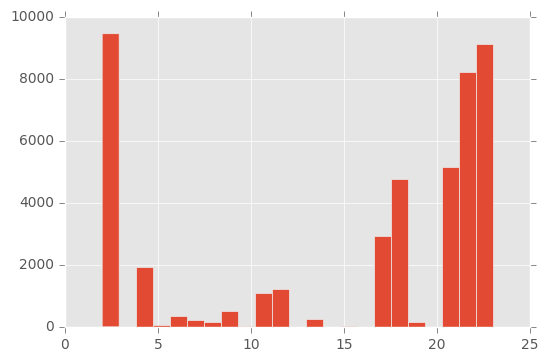

In [6]:
plt.hist(y, bins=23)

In [7]:
def creatTestData(filename, prev_dict, lag_dict):
    with open(filename, 'r') as trainfile:
        X = []
        ids = []
        for row in csv.DictReader(trainfile):
            cust_id = row['ncodpers']
            prev = prev_dict.get(cust_id, [0]*24)
            lag = lag_dict.get(cust_id, [0]*24)
            x_vars = [getColVal(row, col) for col in features]
            X.append(x_vars+prev+lag)
            ids.append(cust_id)
    return np.array(X), ids
X_test, test_ids = creatTestData('../data/input/test.csv', test_prev, test_lag)

In [8]:
import xgboost as xgb

def runXGB(train_X, train_y, params, num_rounds):
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(params, xgtrain, num_rounds)
    return model

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
# params = {'objective': 'multi:softprob',
#          'eta': 0.051,
#          'max_depth': 6,
#          'silent': 0,
#          'num_class': 24,
#          'eval_metric': "mlogloss",
#          'min_child_weight': 2.05,
#          'subsample': 0.92,
#          'gamma': 0.65,
#          'colsample_bytree': 0.9,
#          'seed': 123
#          }
# num_rounds = 115
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.05
param['max_depth'] = 4
param['silent'] = 1
param['num_class'] = 22
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 2
param['subsample'] = 0.9
param['colsample_bytree'] = 0.9
param['seed'] = 125
num_rounds = 190
model = runXGB(X, y, param, num_rounds)

NameError: name 'params' is not defined

In [ ]:
def predictProduct(model, X_test):
    Xtest = xgb.DMatrix(X_test)
    y_pred = model.predict(Xtest)
    y_pred = np.argsort(y_pred, axis=1)
    y_pred = np.fliplr(y_pred)[:,:8]
    return y_pred

y_pred = predictProduct(model, X_test)

In [ ]:
y_pred[0]

In [ ]:
feature_importce = model.get_fscore().values()

In [ ]:
np.argsort(feature_importce)[::-1][:20]

In [ ]:
outputfile = '../data/output/sub_xgb_{}.csv'.format(datetime.now().strftime("%Y-%m-%d-%H-%M"))
with open(outputfile, 'w+') as f:
    f.write('added_products,ncodpers\n')
    for pred, idx in zip(y_pred, test_ids):
        line = " ".join(list(np.array(target_cols)[pred]))
        f.write(line)
        f.write(',')
        f.write(str(idx))
        f.write('\n')